In [1]:
# generate info for station locations from reverse geocode
# basically taken from https://towardsdatascience.com/reverse-geocoding-with-nyc-bike-share-data-cdef427987f8/


In [120]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
geolocator = Nominatim(user_agent="citibikedata_analysis")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1, max_retries=2)

In [28]:
# check e.g. Lincoln Park	-74.078406	40.724605	-73.994156	40.741740   -74.078900	40.711130	-73.994539	40.735439
reverse("40.735439, -73.994539").raw['address']

{'amenity': 'Citi Bike - West 13th Street & 5th Avenue',
 'road': 'West 13th Street',
 'borough': 'Manhattan',
 'county': 'New York County',
 'city': 'City of New York',
 'state': 'New York',
 'ISO3166-2-lvl4': 'US-NY',
 'postcode': '10011',
 'country': 'United States',
 'country_code': 'us'}

In [10]:
# import unique station names with coords
all_years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

imported_df_coords_per_year = {}
stations_analysis_list_all = []
for year in all_years:
    df = pd.read_csv('intermediate_results/df_coords_stations_' + str(year) + '.csv', index_col="Unnamed: 0")
    imported_df_coords_per_year[year] = df
    stations_analysis_list_all.append(df)

# make a single data frame with unique entries
df_all = pd.concat(stations_analysis_list_all, axis=0)
print(len(df_all))

# sum over index to get usage values for all stations
only_usage = pd.DataFrame(df_all["usage"].groupby(level=0).sum())
station_names_to_coords = dict(pd.Series(list(zip(df_all['longitude'], df_all['latitude'])),
                               index=df_all.index).to_dict())
df_coords = pd.DataFrame.from_dict(station_names_to_coords, orient='index')
df_coords = df_coords.rename(columns={0: 'longitude', 1: 'latitude'})
df_coords_all = df_coords.join(only_usage).sort_values('usage', ascending=False)
df_only_coords_all = df_coords_all.drop('usage', axis=1)

print(len(df_only_coords_all))
df_only_coords_all_cleaned = df_only_coords_all[df_only_coords_all['longitude'] != 0]
print(len(df_only_coords_all_cleaned))
df_only_coords_all_cleaned


13980
2756
2748


,longitude,latitude
W 21 St & 6 Ave,-73.994156,40.741740
West St & Chambers St,-74.013221,40.717548
E 17 St & Broadway,-73.990134,40.737006
Broadway & E 14 St,-73.990741,40.734546
8 Ave & W 31 St,-73.994685,40.750585
...,...,...
Forrest portable kiosk,-73.932004,40.703048
StuyTown Depot,-73.993859,40.759030
7 Ave & Bleecker St,-74.003638,40.732139
Sedgwick Ave & W Tremont Ave - new,-73.918306,40.853045


In [8]:
# call reverse function on those 
locations=[]
for index, row in df_only_coords_all_cleaned.iterrows():
    locations.append(reverse("{}, {}".format(row['latitude'],
    row['longitude'])).raw['address'])
df_geocode = pd.DataFrame(locations)
df_geocode.index = df_only_coords_all_cleaned.index

#save out to file
df_geocode.to_csv('intermediate_results/df_geocode_all_stations.csv', index=True)

df_geocode


RateLimiter caught an error, retrying (0/2 tries). Called with (*('40.70684203101325, -73.9544353965357',), **{}).
Traceback (most recent call last):
  File "C:\Users\tzach\anaconda3\Lib\site-packages\urllib3\connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "C:\Users\tzach\anaconda3\Lib\site-packages\urllib3\connection.py", line 507, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tzach\anaconda3\Lib\http\client.py", line 1428, in getresponse
    response.begin()
  File "C:\Users\tzach\anaconda3\Lib\http\client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tzach\anaconda3\Lib\http\client.py", line 292, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tzach\an

,amenity,road,neighbourhood,borough,county,city,state,ISO3166-2-lvl4,postcode,country,...,quarter,residential,highway,farm,industrial,hamlet,emergency,craft,town,region
W 21 St & 6 Ave,Citi Bike - West 21st Street & 6th Avenue,West 21st Street,Chelsea,Manhattan,New York County,City of New York,New York,US-NY,10011,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
West St & Chambers St,NaN,Chambers Street,Tribeca,Manhattan,New York County,City of New York,New York,US-NY,10282,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E 17 St & Broadway,NaN,East 17th Street,Union Square,Manhattan,New York County,City of New York,New York,US-NY,10003,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Broadway & E 14 St,Citi Bike - Broadway & East 14th Street,Broadway,University Village,Manhattan,New York County,City of New York,New York,US-NY,10003,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8 Ave & W 31 St,NaN,8th Avenue,Chelsea,Manhattan,New York County,City of New York,New York,US-NY,10199,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Forrest portable kiosk,NaN,Forrest Street,NaN,Brooklyn,Kings County,City of New York,New York,US-NY,11206,United States,...,Bushwick,NaN,NaN,NaN,NaN,NaN,NaN,Sweet Bella,NaN,NaN
StuyTown Depot,NaN,West 42nd Street,Hell's Kitchen,Manhattan,New York County,City of New York,New York,US-NY,10036,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7 Ave & Bleecker St,St. George Coffee,7th Avenue South,West Village,Manhattan,New York County,City of New York,New York,US-NY,10014,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sedgwick Ave & W Tremont Ave - new,NaN,Sedgwick Avenue,Morris Heights,The Bronx,Bronx County,City of New York,New York,US-NY,10453,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# read in geocode data
df_geocode_all_stations = pd.read_csv('intermediate_results/df_geocode_all_stations.csv', index_col=0)
df_geocode_all_stations = df_geocode_all_stations[df_geocode_all_stations.columns.intersection(['neighbourhood', 'borough', 'city'])]

# annotate generated data with neighbourhood and borough
all_years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
imported_df_coords_per_year = {}
for year in all_years:
    df = pd.read_csv('intermediate_results/df_coords_stations_' + str(year) + '.csv', index_col=0)
    df = df.join(df_geocode_all_stations)
    imported_df_coords_per_year[year] = df

imported_df_coords_per_year[2015]

,longitude,latitude,usage,neighbourhood,borough,city
Pershing Square North,-73.977706,40.751873,200596,Midtown South,Manhattan,City of New York
Lafayette St & E 8 St,-73.990765,40.730287,192231,University Village,Manhattan,City of New York
8 Ave & W 31 St,-73.994442,40.750967,184082,Chelsea,Manhattan,City of New York
E 17 St & Broadway,-73.990093,40.737050,176411,Union Square,Manhattan,City of New York
W 21 St & 6 Ave,-73.994156,40.741740,175016,Chelsea,Manhattan,City of New York
...,...,...,...,...,...,...
Warren St,-74.038051,40.721124,3,Newport,NaN,Jersey City
NYCBS Depot - DYR,-73.993751,40.759088,3,Hell's Kitchen,Manhattan,City of New York
Newark Ave,-74.046305,40.721525,2,Hamilton Park,NaN,Jersey City
Christ Hospital,-74.050444,40.734786,1,Hilltop,NaN,Jersey City


In [71]:
# what neighbourhoods
imported_df_coords_per_year[2015][imported_df_coords_per_year[2015]['borough'] == 'Manhattan'].neighbourhood.unique()

array(['Midtown South', 'University Village', 'Chelsea', 'Union Square',
       'Tribeca', 'SoHo', 'Meatpacking District', 'Flatiron District',
       'Theater District', 'Battery Park City',
       'Manhattan Community Board 4', 'Garment District',
       'Lincoln Square', 'West Village', 'East Village', 'Rose Hill',
       'Koreatown', 'Midtown East', nan, 'Hudson Yards',
       'Manhattan Community Board 6', 'Tudor City', 'Chelsea District',
       'Manhattan Community Board 3', 'Manhattan Community Board 5',
       'Kips Bay', 'Gramercy', 'Turtle Bay', 'NoMad', "Hell's Kitchen",
       'Lower East Side', 'Sutton', 'Murray Hill', 'Two Bridges',
       'Clinton', 'Little Italy', 'Whitehall', 'Hudson Square',
       'Financial District', 'Civic Center', 'Greenwich Village',
       'Beekman', 'Columbus Circle', 'Lenox Hill', 'Yorkville',
       'Manhattan Community Board 7', 'Roosevelt Island',
       'Manhattan Community Board 8', 'Nolan Park'], dtype=object)

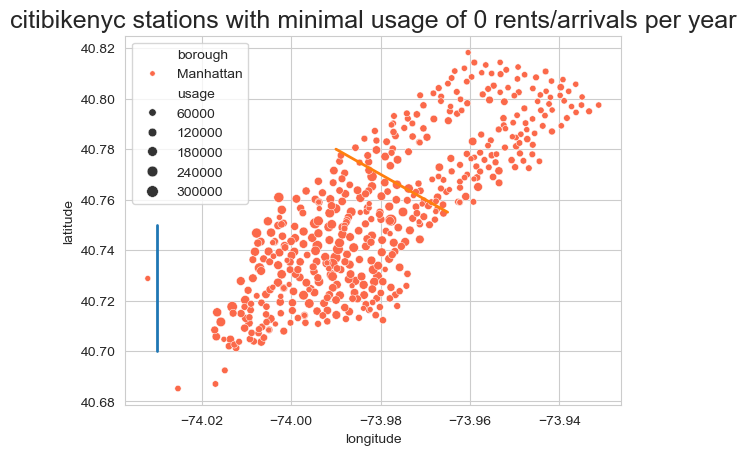

In [119]:
min_usage = 0

df_coords_total_min_usage = imported_df_coords_per_year[2019]
df_coords_total_min_usage = df_coords_total_min_usage[df_coords_total_min_usage['longitude'] != 0]
df_coords_total_min_usage = df_coords_total_min_usage[df_coords_total_min_usage['usage'] > min_usage]
# now restrict to regions under central park, which basically present from 2013 on...
# function: y = (40.755 - 40.78)/(-73.965 + 73.99) * (x + 73.965) + 40.755 
# and vertical line at longitude -74.03
df_coords_total_min_usage = df_coords_total_min_usage[df_coords_total_min_usage['borough'] == 'Manhattan']
#df_coords_total_min_usage = df_coords_total_min_usage[(df_coords_total_min_usage['latitude'] < (((df_coords_total_min_usage['longitude'] + 73.965)*((40.755 - 40.78)/(-73.965 + 73.99)) ) + 40.755)) & (df_coords_total_min_usage['longitude'] > -74.03)]

sns.set_style("whitegrid")
#norm = plt.Normalize(df_coords_total_min_usage['usage'].min(), df_coords_total_min_usage['usage'].max())
#sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
#sm.set_array([])

fig, ax = plt.subplots()

#fig = sns.scatterplot(data=df_coords_total_min_usage, x="longitude", y="latitude", s=15, hue='usage', palette='Reds')
fig = sns.scatterplot(data=df_coords_total_min_usage, x="longitude", y="latitude", s=15, size='usage', hue='borough', palette='Reds')
fig.set_title("citibikenyc stations with minimal usage of " + str(min_usage) + " rents/arrivals per year", size=18)

# Remove the legend and add a colorbar
#fig.get_legend().remove()
#fig.figure.colorbar(sm, ax=ax)
df_coords_total_min_usage

plt.plot([-74.03, -74.03], [40.7, 40.75], linewidth=2)
plt.plot([-73.965, -73.99], [40.755, 40.78], linewidth=2)
#plt.ylim(40.65, 40.80)

In [95]:
imported_df_coords_per_year[2019][imported_df_coords_per_year[2019]['borough'] == 'Manhattan']

,longitude,latitude,usage,neighbourhood,borough,city
Pershing Square North,-73.977706,40.751873,312111,Midtown South,Manhattan,City of New York
E 17 St & Broadway,-73.990093,40.737050,247247,Union Square,Manhattan,City of New York
8 Ave & W 31 St,-73.994685,40.750585,241589,Chelsea,Manhattan,City of New York
Broadway & E 22 St,-73.989551,40.740343,236284,Flatiron District,Manhattan,City of New York
Broadway & E 14 St,-73.990741,40.734546,227190,University Village,Manhattan,City of New York
...,...,...,...,...,...,...
58th St Depot,-73.983838,40.716910,10,Lower East Side,Manhattan,City of New York
Newport Pkwy,-74.032108,40.728745,9,Newport,Manhattan,Jersey City
NYCBS Depot BAL - DYR,-73.993859,40.759030,6,Hell's Kitchen,Manhattan,City of New York
W 39 St & 9 Ave,-73.993722,40.756458,6,Hudson Yards,Manhattan,City of New York
